In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to c:\users\mehdi\appdata\local\temp\pip-req-build-zwco_j_g
  Resolved https://github.com/albumentations-team/albumentations to commit 63da7b725d89c2c74adba6a3ad8713fbd0fff2c1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for albumentations: filename=albumentations-1.4.21-py3-none-any.whl size=229996 sha256=4d01dc9f2d62257e9230b4b53acd79a52f18317f9f2081767e55e14c2fd07ec5
  Stored in directory: C:\Users\Mehdi\AppData\Local\Temp\pip-ephem-wheel-cache-ctwynx1n\wheels\c5\43\65\96f74b58b1b29c6c1a3eb012744b9efc61c76f0cfd212b3e01
Successfully built albumentations
  Attempting uninstall: albucore
    Found existing installation: albucor

  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\Mehdi\AppData\Local\Temp\pip-req-build-zwco_j_g'


# Siamese Network with Anchor, Positive, and Negative Examples
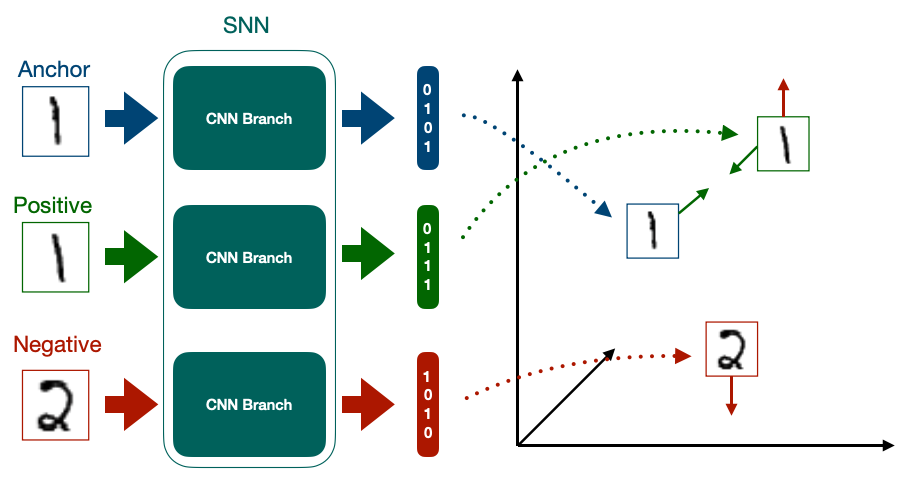

In a **Siamese network**, we use three main concepts for training:
- **Anchor**: A reference sample for which we want to find similarities or dissimilarities.
- **Positive**: A sample that is similar to or of the same class as the anchor.
- **Negative**: A sample that is different or of a different class than the anchor.

These concepts are used to train the network to distinguish between similar and dissimilar items effectively.

## How It Works

In a Siamese network, the anchor, positive, and negative samples are passed through the same neural network (or subnetworks with shared weights) to produce embeddings (vector representations) for each input.

1. **Anchor (A)**: The reference sample.
2. **Positive (P)**: The sample similar to the anchor.
3. **Negative (N)**: The sample dissimilar to the anchor.

The network learns to minimize the distance between the anchor and positive embeddings while maximizing the distance between the anchor and negative embeddings.

## Triplet Loss

The **Triplet Loss** function is commonly used to train Siamese networks. It ensures that:
- The distance between the anchor and positive is minimized.
- The distance between the anchor and negative is maximized.

The Triplet Loss formula is as follows:

$$
L = \max \left( d(a, p) - d(a, n) + \alpha, 0 \right)
$$

Where:
- $a$ represents the embedding of the anchor.
- $p$ represents the embedding of the positive.
- $n$ represents the embedding of the negative.
- $d(x, y)$ is a distance function (e.g., Euclidean distance or cosine similarity).
- $\alpha$ is a **margin** that defines a minimum difference between the positive and negative pairs.

### Explanation of the Loss Function
- **Minimizing** $d(a, p)$: Reduces the distance between the anchor and positive embeddings, making them closer.
- **Maximizing** $d(a, n)$: Increases the distance between the anchor and negative embeddings, making them further apart.
- **Margin $\alpha$**: Ensures that the negative is not only different but separated by at least $\alpha$ distance.

This helps the network learn embeddings that capture the similarity structure of the data.



# Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [11]:
DATA_DIR = 'Person-Re-Id-Dataset/train/'
CSV_FILE = 'Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-3

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [13]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative) 

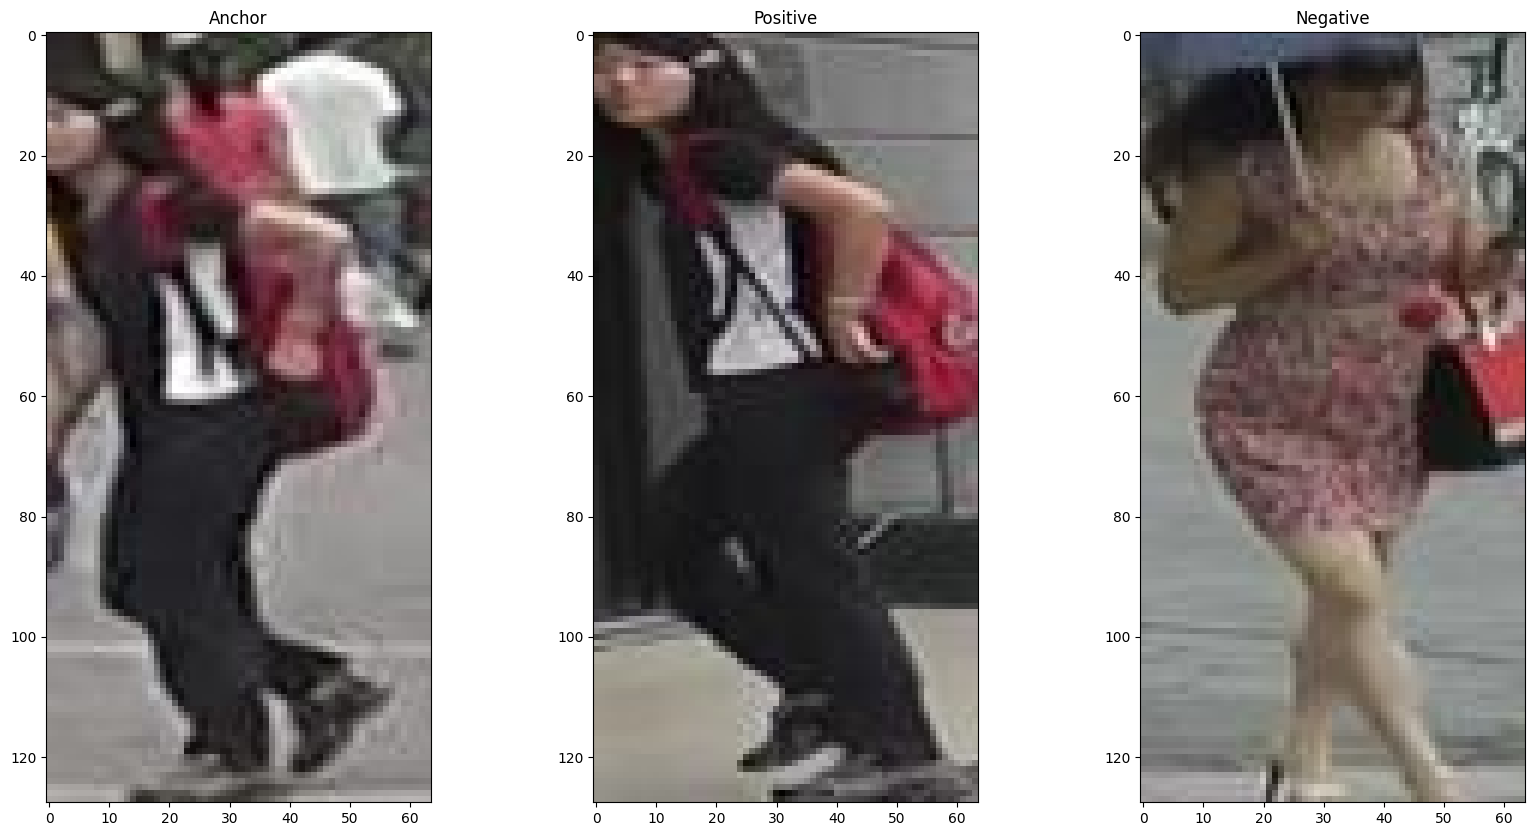

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [15]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Create APN Dataset

In [19]:
class APN_Dataset(Dataset):

    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative)

        A_img = torch.from_numpy(A_img).permute(2, 0, 1).float() / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0, 1).float() / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0, 1).float() / 255.0 

        return A_img, P_img, N_img

In [20]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

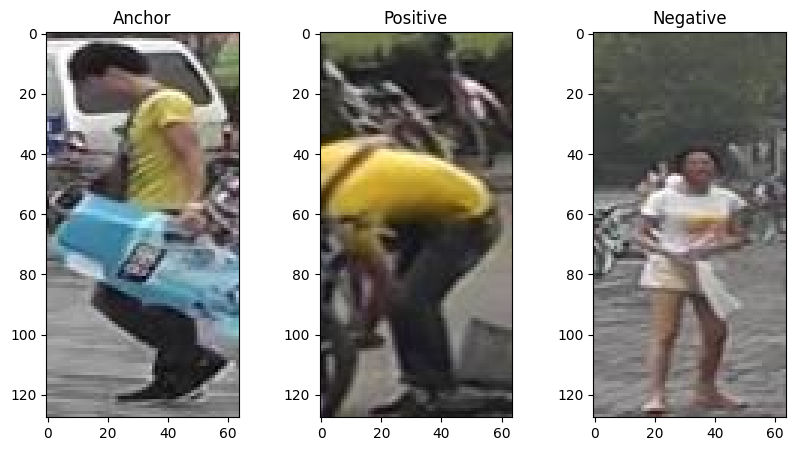

In [21]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [22]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [25]:
for A, P, N in trainloader:
    print(f"One batch of A shape : {A.shape}")
    print(f"One batch of P shape : {P.shape}")
    print(f"One batch of N shape : {N.shape}")
    break

One batch of A shape : torch.Size([32, 3, 128, 64])
One batch of P shape : torch.Size([32, 3, 128, 64])
One batch of N shape : torch.Size([32, 3, 128, 64])


# Create Model

In [30]:
class APN_Model(nn.Module):

    def __init__(self, emb_size=512):
        super(APN_Model, self).__init__()

        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features=emb_size)

    def forward(self, images):
        
        embeddings = self.efficientnet(images)

        return embeddings

In [33]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [34]:
def train_fn(model, dataloader, optimizer, criterion):

    model.train() # on dropout
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):

        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        loss = criterion(A_embs, P_embs, N_embs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [41]:
def eval_fn(model, dataloader, optimizer, criterion):

    model.eval() # OFF dropout
    total_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):

            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [42]:
critertion = nn.TripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Create Training Loop

In [43]:
best_valid_loss = float('inf')

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer, critertion)
    valid_loss = eval_fn(model, validloader, optimizer, critertion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print(f"Model saved at epoch {i}")
    
    print(f"Epoch : {i} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:10<00:00,  2.32it/s]


Model saved at epoch 0
Epoch : 0 Train Loss : 0.403993573486805 Valid Loss : 0.3614464712142944


100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


Model saved at epoch 1
Epoch : 1 Train Loss : 0.1870686461031437 Valid Loss : 0.22990367650985719


100%|██████████| 25/25 [00:04<00:00,  5.01it/s]


Epoch : 2 Train Loss : 0.11609362713992595 Valid Loss : 0.25543603718280794


100%|██████████| 25/25 [00:04<00:00,  5.18it/s]


Model saved at epoch 3
Epoch : 3 Train Loss : 0.12924311608076094 Valid Loss : 0.14961178511381149


100%|██████████| 25/25 [00:05<00:00,  4.87it/s]


Epoch : 4 Train Loss : 0.04714913435280323 Valid Loss : 0.18030870139598845


100%|██████████| 25/25 [00:05<00:00,  4.24it/s]


Epoch : 5 Train Loss : 0.044196381866931915 Valid Loss : 0.1859703278541565


100%|██████████| 25/25 [00:06<00:00,  4.08it/s]


Epoch : 6 Train Loss : 0.07032921202480794 Valid Loss : 0.15325096547603606


100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


Epoch : 7 Train Loss : 0.06049207732081413 Valid Loss : 0.2317665472626686


100%|██████████| 25/25 [00:05<00:00,  4.54it/s]


Epoch : 8 Train Loss : 0.04304928570985794 Valid Loss : 0.17165959477424622


100%|██████████| 25/25 [00:05<00:00,  4.56it/s]


Model saved at epoch 9
Epoch : 9 Train Loss : 0.021962527185678482 Valid Loss : 0.13901369839906694


100%|██████████| 25/25 [00:06<00:00,  4.04it/s]


Epoch : 10 Train Loss : 0.03385380282998085 Valid Loss : 0.21795962393283844


100%|██████████| 25/25 [00:05<00:00,  4.41it/s]


Epoch : 11 Train Loss : 0.07103228129446507 Valid Loss : 0.17183996558189393


100%|██████████| 25/25 [00:05<00:00,  4.65it/s]


Epoch : 12 Train Loss : 0.028246138095855713 Valid Loss : 0.19418231308460235


100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


Epoch : 13 Train Loss : 0.030843733251094817 Valid Loss : 0.14379005908966064


100%|██████████| 25/25 [00:05<00:00,  4.34it/s]

Epoch : 14 Train Loss : 0.03635620623826981 Valid Loss : 0.18881204426288606


# Get Anchor Embeddings

In [76]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():  # dropout off
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1).float() / 255.0
            A = A.to(DEVICE)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().numpy())  # Move tensor to CPU before converting

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([pd.DataFrame(anc_img_names), encodings], axis=1)  # Wrap anc_img_names in DataFrame

    return df_enc


In [71]:
model.load_state_dict(torch.load('best_model.pt'))

C:\Users\Mehdi\AppData\Local\Temp\ipykernel_4376\387697859.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
100%|██████

In [78]:
df_enc = get_encoding_csv(model, df['Anchor'])

  5%|▍         | 197/4000 [00:02<00:47, 80.70it/s]


KeyboardInterrupt: 

In [79]:
df_enc.to_csv('database.csv', index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,0.999954,-0.182253,-0.539868,-0.419867,-0.710686,-0.758091,0.171692,-0.230584,0.430074,...,0.036576,0.035667,-0.613354,-0.469741,0.863896,-0.086488,-0.128649,0.144494,0.389153,-0.455021
1,1420_c3s3_061978_03.jpg,0.974206,-0.191964,-0.609841,-0.191943,-0.405158,-0.594808,-0.210701,0.109472,0.563485,...,0.199978,0.286068,-0.778533,-0.284219,0.970031,-0.096270,-0.158367,0.183835,0.725628,-0.037911
2,1420_c5s3_062565_05.jpg,0.660996,-0.334716,-0.805978,-0.635817,-0.703840,-1.066289,-0.063645,-0.092090,0.551594,...,0.089293,-0.046498,-0.389025,-0.508430,1.006075,0.369546,0.047438,0.279334,0.557714,-0.301913
3,1420_c6s3_085592_04.jpg,1.025316,-0.021622,-0.190346,0.153129,-0.296447,-0.065186,0.588416,0.103433,0.322582,...,0.522212,0.238562,-0.942548,-0.397524,0.733386,-0.582067,-0.246544,0.020042,0.483600,-0.199048
4,0663_c5s3_085987_03.jpg,-0.807636,0.823326,-0.105333,1.752662,1.217391,0.942770,1.270843,0.347294,-0.047393,...,1.222138,-0.390262,0.099491,0.016234,-0.444554,-0.636847,-0.469792,-0.244506,0.796864,0.231935


# Inference

In [55]:
def euclidean_distance(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
    return dist

In [69]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.squeeze().cpu().detach().numpy()

In [80]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [81]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_distance(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)
    

In [82]:
closest_idx = np.argsort(distance)

d:\anaconda\envs\venv\Lib\site-packages\networkx\drawing\layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


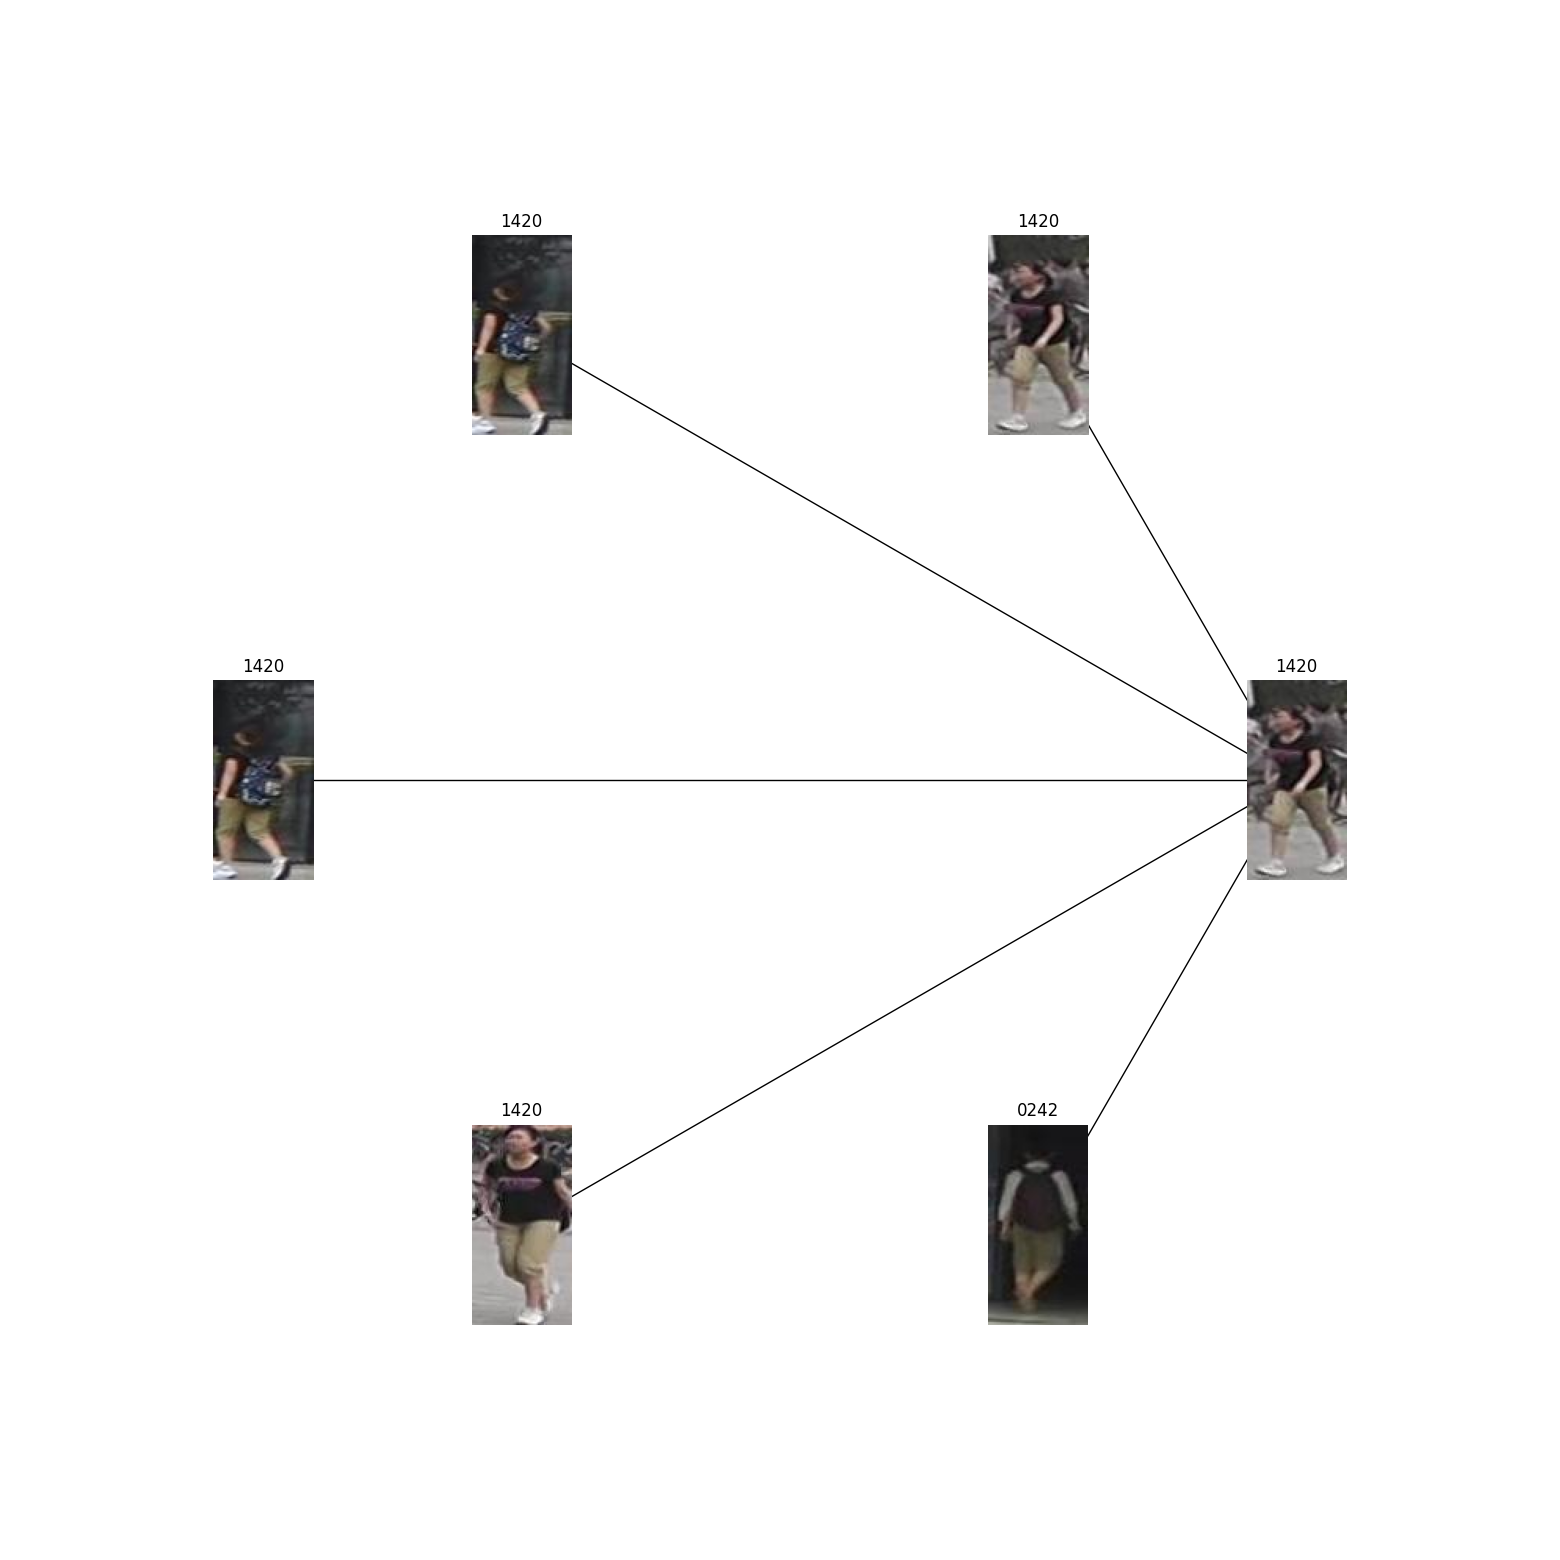

In [83]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);